# ИиСМ, Журик Н.С., группа 6, курс 4, ЛР 2

In [1]:
import numpy as np
import scipy as sp
from scipy import stats

import sys
sys.path.append('../')

from utils import *
from BaseUniform.statmod1 import UniformDistribution

Навскидку существует около двух способов сгенерировать данную СВ.

Первый скорее общий, подходит для произвольных дискретных СВ и основан на построении функции, обратной к функции распределения: построим кумулятивную функцию распределения и найдём значение СВ, соответствующее верхней границе сгенерированной БСВ в массиве CDF. То есть,

$$\xi = \text{upper_bound(CDF, Uniform(0, 1))}$$

Второй же заключается в построении СВ по определению: по сути, "вытягиванием шаров" вручную.

Реализуем оба.

In [3]:
class HypergeometricDistributionInverse:
    def __init__(self, N: int, D: int, n: int, seed: int = 1):
        '''
            Generate hypergeometrically distributed random variable
            @param[in] N - population size
            @param[in] D - successes in population
            @param[in] n - number of trials 
        '''
        self.pop_size = N
        self.good_size = D
        self.trials = n
        self.seed = seed
        self.uniform_dist = UniformDistribution(seed=self.seed)
        total_combinations = sp.special.comb(self.pop_size, self.trials, exact=True)
        k_proba = lambda k: (sp.special.comb(self.good_size, k, exact=True) *
                             sp.special.comb(self.pop_size - self.good_size, self.trials - k, exact=True) /
                             total_combinations
                            )
        self.cdf = np.cumsum(np.array([k_proba(k) for k in range(self.trials + 1)]))
        
    def mean(self):
        return self.trials * self.good_size / self.pop_size
    
    def __call__(self, shape: tuple):
        '''
            Find number of successful trials, k, by finding upper bound of CDF
        '''
        def generate_value():
            def upper_bound(p, l, r):
                mid = (l + r) // 2
                if l == r:  # one element
                    return r if p < self.cdf[r] else -1
                if p >= self.cdf[mid]:
                    return upper_bound(p, mid + 1, r)
                elif p < self.cdf[mid]:
                    if mid == 0 or self.cdf[mid - 1] < p:
                        return mid
                    return upper_bound(p, l, mid - 1)
            return upper_bound(self.uniform_dist((1,)), 0, self.cdf.size - 1)
        
        n = np.prod(shape)
        random_value = np.empty(n)
        for i in range(n):
            random_value[i] = generate_value()
        return random_value.reshape(*shape)

In [4]:
class HypergeometricDistributionManual:
    def __init__(self, N: int, D: int, n: int, seed: int = 1):
        '''
            Generate hypergeometrically distributed random variable
            @param[in] N - population size
            @param[in] D - successes in population
            @param[in] n - number of trials 
        '''
        self.pop_size = N
        self.good_size = D
        self.trials = n
        self.seed = seed
        self.uniform_dist = UniformDistribution(low=0, high=self.pop_size, seed=self.seed)
        
    def mean(self):
        return self.trials * self.good_size / self.pop_size
    
    def __call__(self, shape: tuple):
        '''
            Find number of successful trials, k, by repeatedly sampling objects
            from population without returning them
        '''
        def generate_value():
            successful_trials = 0
            for i in range(self.trials):
                index = int(self.uniform_dist(shape=(1,)))
                while index >= self.pop_size - i:
                    index = int(self.uniform_dist(shape=(1,)))
                successful_trials += index < self.good_size - successful_trials
            return successful_trials
        
        n = np.prod(shape)
        random_value = np.empty(n)
        for i in range(n):
            random_value[i] = generate_value()
        return random_value.reshape(*shape)

In [5]:
def rv_test_pipeline_hypergeom(dist, np_dist, dist_pmf):
    sampling_sizes = [30, 50, 100, 300, 500, 1000]

    seqs = []
    means = []
    stds = []

    np_seqs = []
    np_means = []
    np_stds = []

    for sampling_size in sampling_sizes:
        generated = dist(shape=(sampling_size,))
        np_seqs.append(np_dist(size=sampling_size))
        seqs.append(generated)
        means.append(seqs[-1].mean())
        stds.append(seqs[-1].std())
        np_means.append(np_seqs[-1].mean())
        np_stds.append(np_seqs[-1].std())
        print(f'Mean for {sampling_size} values: {means[-1]}')
        print(f'Std for {sampling_size} values: {stds[-1]}')

    means = np.array(means)
    stds = np.array(means)
    np_means = np.array(np_means)
    np_stds = np.array(np_stds)
    plot_conv_comparison(sampling_sizes, means, np_means, exact_mean=dist.mean())
    plot_autocov_comparison(seqs[-1], np_seqs[-1])
    plot_scatter_comparison(seqs[3], np_seqs[3])
    plot_hist_comparison(seqs[-1], np_seqs[-1])
    
    n_bins_chi2 = min(dist.trials, dist.good_size)
    discrete_values = np.arange(n_bins_chi2)
    values_proba = np.array([dist_pmf(value) for value in discrete_values])
    low = 0
    high = dist.trials
    EPS = 0.05

    for i in range(len(seqs)):
        seq = seqs[i]
        p_value = find_chi2_p_value(discrete_chi2(seq, discrete_values, values_proba), r=n_bins_chi2-1)
        np_p_value = find_chi2_p_value(discrete_chi2(np_seqs[i], discrete_values, values_proba), r=n_bins_chi2-1)
        print(f'P-value for seq with {seq.size} elements: {p_value}')
        print(f'P-value for np with {seq.size} elements: {np_p_value}')
        print(f'Null-hypothesis (hypergeometrically distributed) is correct: {p_value > EPS}')
        print()

Mean for 30 values: 2.933333333333333
Std for 30 values: 1.1527744310527057
Mean for 50 values: 2.72
Std for 50 values: 1.1320777358467924
Mean for 100 values: 2.71
Std for 100 values: 1.2906974858579372
Mean for 300 values: 2.91
Std for 300 values: 1.5303267624922463
Mean for 500 values: 3.086
Std for 500 values: 1.4305956801276871
Mean for 1000 values: 2.896
Std for 1000 values: 1.4110931932370732


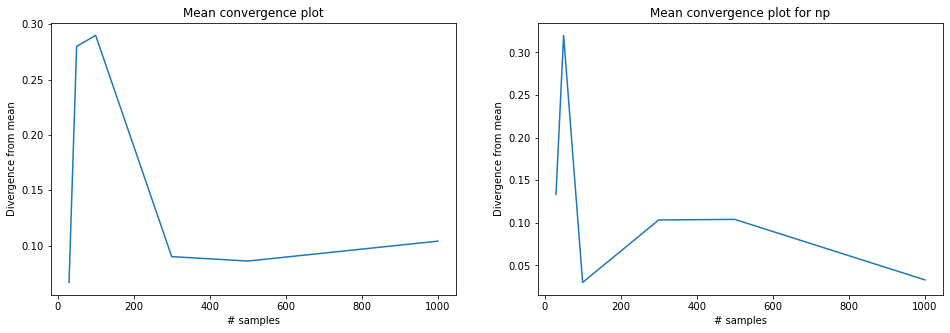

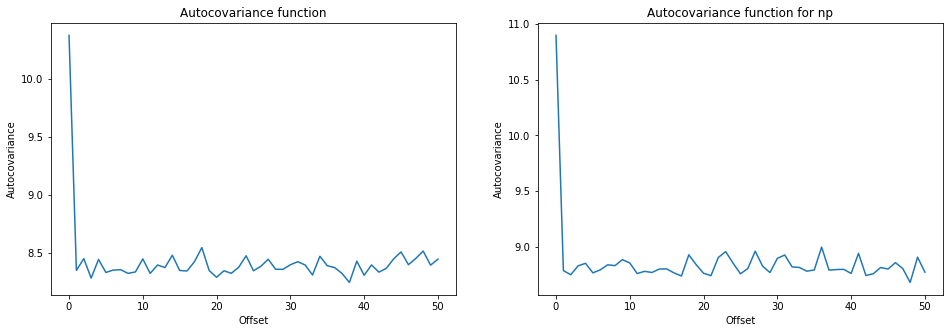

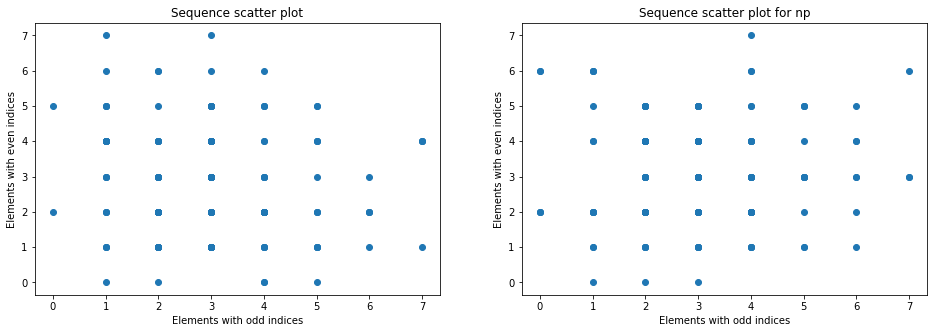

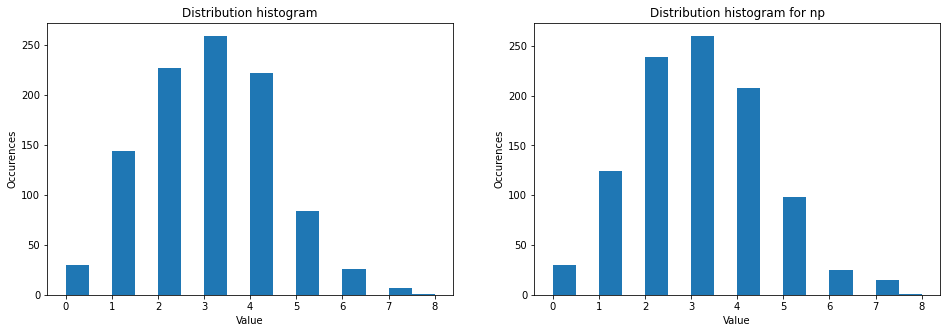

P-value for seq with 30 elements: 0.9975526398852623
P-value for np with 30 elements: 0.7842709449885974
Null-hypothesis (hypergeometrically distributed) is correct: True

P-value for seq with 50 elements: 0.978015427026522
P-value for np with 50 elements: 5.551115123125783e-16
Null-hypothesis (hypergeometrically distributed) is correct: True

P-value for seq with 100 elements: 0.9882540693776795
P-value for np with 100 elements: 0.8600481503773565
Null-hypothesis (hypergeometrically distributed) is correct: True

P-value for seq with 300 elements: 0.35866375108501325
P-value for np with 300 elements: 0.9959748431790874
Null-hypothesis (hypergeometrically distributed) is correct: True

P-value for seq with 500 elements: 0.22905579247825492
P-value for np with 500 elements: 0.9693590757653007
Null-hypothesis (hypergeometrically distributed) is correct: True

P-value for seq with 1000 elements: 0.36694369045580666
P-value for np with 1000 elements: 0.8066158414488553
Null-hypothesis (hyp

In [6]:
if __name__ == "__main__":
    total = 100
    bad = 20
    n = 15

    rng = np.random.default_rng()

    rv_test_pipeline_hypergeom(HypergeometricDistributionInverse(total, bad, n, seed=1),
                               lambda size: rng.hypergeometric(bad, total - bad, n, size=size),
                               stats.hypergeom(M=total, n=bad, N=n).pmf)

Mean for 30 values: 3.6333333333333333
Std for 30 values: 1.4487542541400487
Mean for 50 values: 2.82
Std for 50 values: 1.351887569289695
Mean for 100 values: 3.08
Std for 100 values: 1.5406492138056604
Mean for 300 values: 3.1766666666666667
Std for 300 values: 1.599621483004304
Mean for 500 values: 2.982
Std for 500 values: 1.3422652494943017
Mean for 1000 values: 3.048
Std for 1000 values: 1.4531675746451267


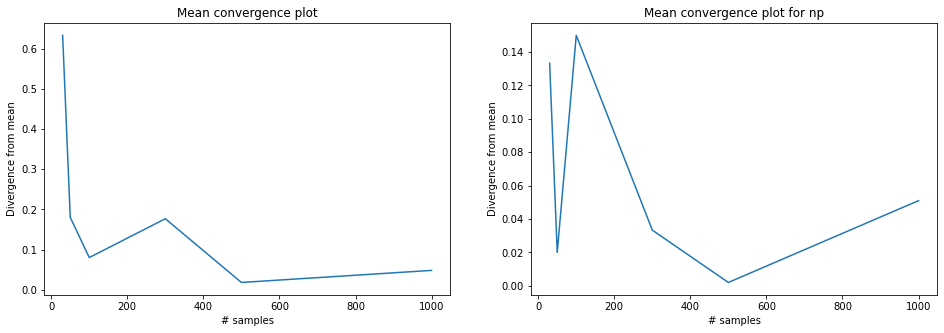

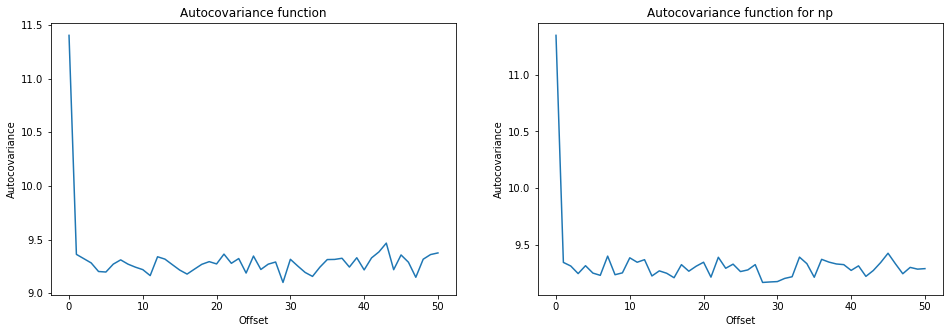

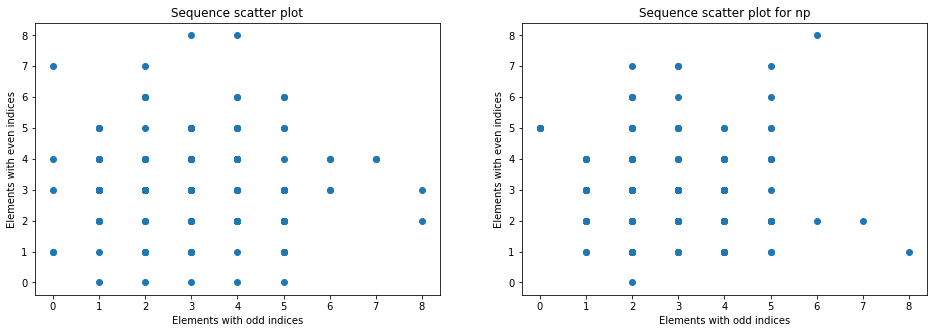

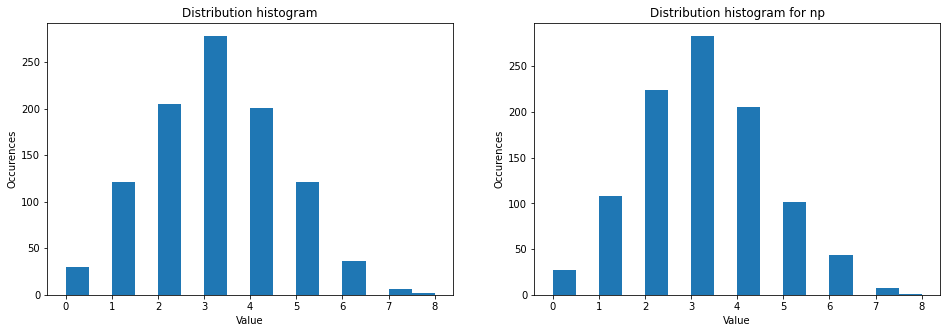

P-value for seq with 30 elements: 0.9306675616502181
P-value for np with 30 elements: 0.36786038193369897
Null-hypothesis (hypergeometrically distributed) is correct: True

P-value for seq with 50 elements: 0.9865313183361131
P-value for np with 50 elements: 0.22239255800463087
Null-hypothesis (hypergeometrically distributed) is correct: True

P-value for seq with 100 elements: 3.4742472531101853e-06
P-value for np with 100 elements: 0.9787749457942819
Null-hypothesis (hypergeometrically distributed) is correct: False

P-value for seq with 300 elements: 0.001468635910320093
P-value for np with 300 elements: 0.5148841906687474
Null-hypothesis (hypergeometrically distributed) is correct: False

P-value for seq with 500 elements: 0.7222175048179887
P-value for np with 500 elements: 0.8797425475326862
Null-hypothesis (hypergeometrically distributed) is correct: True

P-value for seq with 1000 elements: 0.7436968174689311
P-value for np with 1000 elements: 0.9828720848496428
Null-hypothesis

In [8]:
if __name__ == "__main__":
    rv_test_pipeline_hypergeom(HypergeometricDistributionManual(total, bad, n, seed=1),
                               lambda size: rng.hypergeometric(bad, total - bad, n, size=size),
                               stats.hypergeom(M=total, n=bad, N=n).pmf)

# Выводы

Видим, что оба генератора работают корректно: p-value свидетельствует о том, что нулевая гипотеза верна. Однако генератор, основанный на построении кумулятивной функции распределения работает значительно быстрее, так как основной объём вычислений производится во время препроцессинга, а именно инициализации генератора. В любом случае, такой генератор эффективнее "наивного" (биномиальные коэффициенты вычисляются точно, без использования аппроксимаций вроде формулы Стирлинга):

1. Инициализация: $O(Nn)$ vs $O(1)$
2. Генерация выборки из $S$ объектов: $O(S\log{n})$ vs $O(Sn)$

    в лучшем случае (вообще говоря, правильнее будет оценить матожидание сложности, так как сложность генерации одного объекта "наивным" генератором - случайная величина).
    
Таким образом, имеем: $O(Nn + S\log{n})$ vs $O(Sn)$ на генерацию одной выборки. Если стоит задача сгенерировать большую выборку, второй генератор даже с учётом времени на инициализацию проигрывает первому. При генерации нескольких выборок первый генератор также предпочтительнее.